In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [37]:
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
import fastai
fastai.defaults.device = torch.device('cpu')

In [4]:
from fastai.callbacks import *

In [5]:
import myutils as my

In [6]:
def create_head_sigmoid(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5):
    """Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes.
    :param ps: dropout, can be a single float or a list for each layer."""
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.Sigmoid()] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    del(layers[-3])
    return nn.Sequential(*layers)

In [7]:
path = Path('data/mnist_png/')
classes = list(range(8))
head = create_head_sigmoid(1024,8,lin_ftrs=[48])

In [8]:
tfms = get_transforms(do_flip=False)
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=tfms, size=26)

In [9]:
learner = create_cnn(data2, models.resnet18, custom_head=head).load('test')

In [10]:
flatten_model(learner.model)[-1].out_features

8

In [11]:
class StoreHook(Callback):
    def __init__(self, module):
        super().__init__()
        self.custom_hook = hook_output(module)
        self.outputs = []
        
    def on_batch_end(self, train, **kwargs): 
        if (not train): self.outputs.append(self.custom_hook.stored.numpy())

In [12]:
nn_module = learner.model[-1][-3]
learner.callbacks = [ StoreHook(nn_module) ]

In [13]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=48, bias=True)
  (5): Sigmoid()
  (6): Dropout(p=0.5)
  (7): Linear(in_features=48, out_features=8, bias=True)
)

In [14]:
nn_module

Sigmoid()

In [15]:
for i in (path/'9').iterdir():
    print(i)

data/mnist_png/9/22.png
data/mnist_png/9/48.png
data/mnist_png/9/4.png
data/mnist_png/9/428.png
data/mnist_png/9/764.png
data/mnist_png/9/78.png
data/mnist_png/9/33.png
data/mnist_png/9/116.png
data/mnist_png/9/800.png
data/mnist_png/9/601.png
data/mnist_png/9/176.png
data/mnist_png/9/227.png
data/mnist_png/9/383.png
data/mnist_png/9/282.png
data/mnist_png/9/520.png
data/mnist_png/9/154.png
data/mnist_png/9/267.png
data/mnist_png/9/153.png
data/mnist_png/9/471.png
data/mnist_png/9/727.png
data/mnist_png/9/362.png
data/mnist_png/9/482.png
data/mnist_png/9/589.png
data/mnist_png/9/423.png
data/mnist_png/9/460.png
data/mnist_png/9/319.png
data/mnist_png/9/826.png
data/mnist_png/9/424.png
data/mnist_png/9/621.png
data/mnist_png/9/580.png
data/mnist_png/9/58.png
data/mnist_png/9/550.png
data/mnist_png/9/793.png
data/mnist_png/9/226.png
data/mnist_png/9/313.png
data/mnist_png/9/827.png
data/mnist_png/9/741.png
data/mnist_png/9/350.png
data/mnist_png/9/57.png
data/mnist_png/9/12.png
data/mnis

In [16]:
learner.callbacks[0].outputs = []
my.run_folder(path/'9', learner)

In [17]:
test = learner.callbacks[0].outputs

In [18]:
ref = np.array([], dtype=np.int64).reshape(0,48)
for row in test:
    ref = np.vstack([ref, row])
    

In [28]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

In [30]:
mu, sigma = estimateGaussian(ref)

In [ ]:
.hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

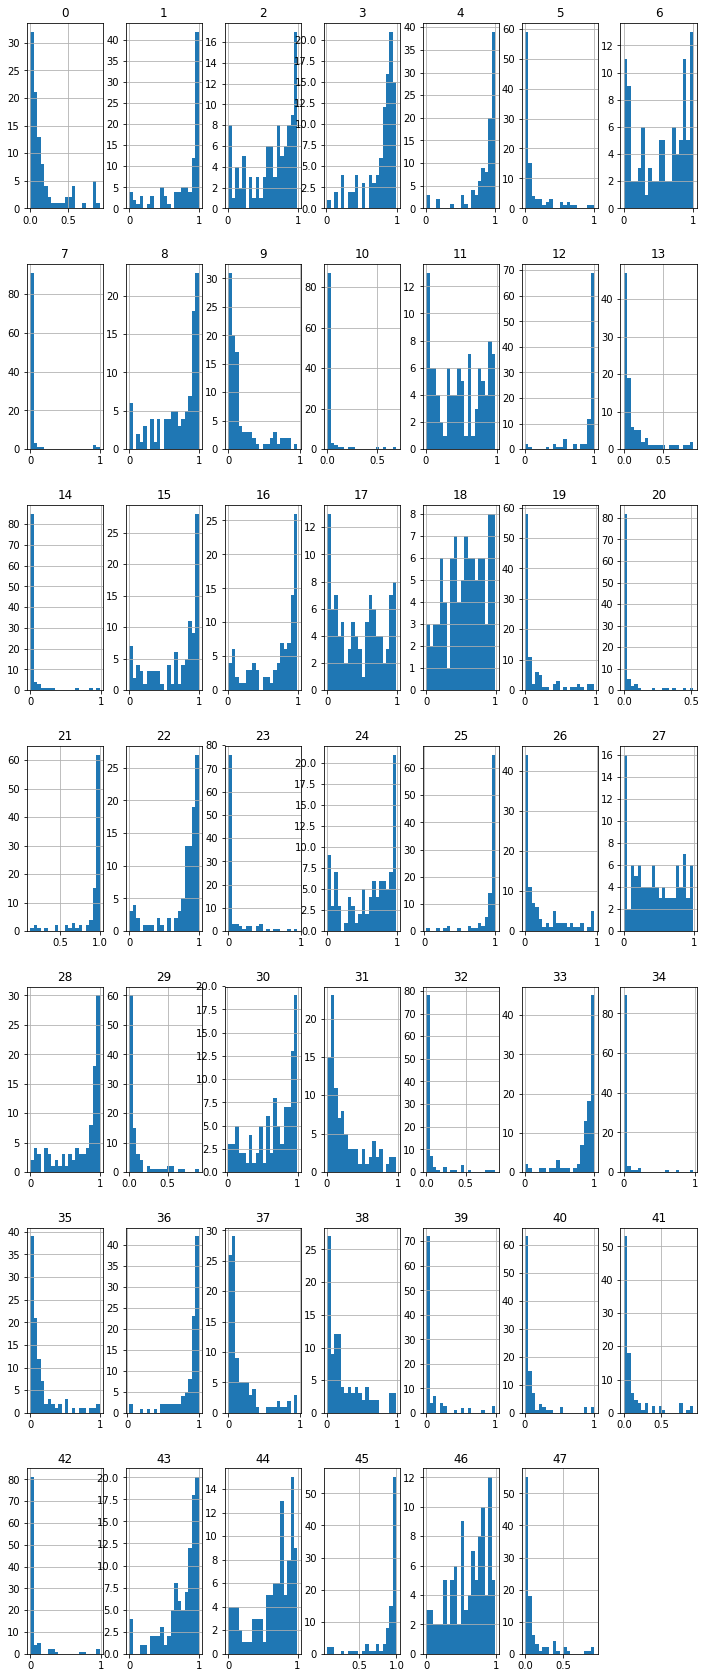

In [55]:
pd.DataFrame(ref).hist(stacked=False,figsize=(12,30), bins=20);

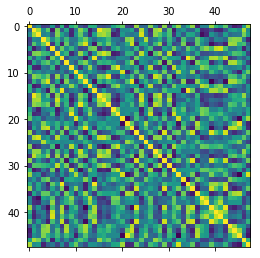

In [56]:
plt.matshow(pd.DataFrame(ref).corr());


In [35]:
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

In [38]:
p = multivariateGaussian(ref,mu,sigma)

In [44]:
max(p), min(p)

(1.0168696785731582e+39, 1.2083553373869706e+21)

In [196]:
def selectThresholdByCV(probs,gt):
    set_trace()
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

In [120]:
lst_9cv = list((path/'9cv').iterdir())

In [124]:
lst_9cv

[PosixPath('data/mnist_png/9cv/616.png'),
 PosixPath('data/mnist_png/9cv/417.png'),
 PosixPath('data/mnist_png/9cv/560.png'),
 PosixPath('data/mnist_png/9cv/471.png'),
 PosixPath('data/mnist_png/9cv/634.png'),
 PosixPath('data/mnist_png/9cv/281.png'),
 PosixPath('data/mnist_png/9cv/593.png'),
 PosixPath('data/mnist_png/9cv/558.png'),
 PosixPath('data/mnist_png/9cv/630.png'),
 PosixPath('data/mnist_png/9cv/320.png'),
 PosixPath('data/mnist_png/9cv/521.png'),
 PosixPath('data/mnist_png/9cv/627.png'),
 PosixPath('data/mnist_png/9cv/562.png'),
 PosixPath('data/mnist_png/9cv/488.png'),
 PosixPath('data/mnist_png/9cv/426.png'),
 PosixPath('data/mnist_png/9cv/394.png'),
 PosixPath('data/mnist_png/9cv/336.png'),
 PosixPath('data/mnist_png/9cv/530.png'),
 PosixPath('data/mnist_png/9cv/487.png'),
 PosixPath('data/mnist_png/9cv/662.png'),
 PosixPath('data/mnist_png/9cv/639.png'),
 PosixPath('data/mnist_png/9cv/274.png'),
 PosixPath('data/mnist_png/9cv/434.png'),
 PosixPath('data/mnist_png/9cv/389

In [142]:
gt = [1]*len(lst_9cv)

In [144]:
len(gt)

40

In [123]:
fraud_cls = ['0','1','2','3','4','5','6','7','8']

In [136]:
test = (path/'9cv').iterdir()


In [138]:
next(test)

PosixPath('data/mnist_png/9cv/616.png')

In [175]:
def run_folder(path, Learner):
    for i in (path).iterdir():
        print(i)
        Learner.predict(open_image(i))

In [177]:
my.run_folder(path/'cv', learner)

In [217]:
learner.callbacks[0].outputs = []
run_folder(path/'7', learner)

In [140]:
lst_fr = []
nb = 2
for cls in fraud_cls:
    folder = (path/cls).iterdir()
    for i in range(nb):
        lst_fr.append(next(folder))
        

In [141]:
lst_fr

[PosixPath('data/mnist_png/0/37.png'),
 PosixPath('data/mnist_png/0/56.png'),
 PosixPath('data/mnist_png/1/3.png'),
 PosixPath('data/mnist_png/1/23.png'),
 PosixPath('data/mnist_png/2/117.png'),
 PosixPath('data/mnist_png/2/28.png'),
 PosixPath('data/mnist_png/3/30.png'),
 PosixPath('data/mnist_png/3/44.png'),
 PosixPath('data/mnist_png/4/53.png'),
 PosixPath('data/mnist_png/4/2.png'),
 PosixPath('data/mnist_png/5/138.png'),
 PosixPath('data/mnist_png/5/65.png'),
 PosixPath('data/mnist_png/6/18.png'),
 PosixPath('data/mnist_png/6/90.png'),
 PosixPath('data/mnist_png/7/1338.png'),
 PosixPath('data/mnist_png/7/1106.png'),
 PosixPath('data/mnist_png/8/94.png'),
 PosixPath('data/mnist_png/8/137.png')]

In [145]:
lst_cv = lst_9cv + lst_fr

In [146]:
len(lst_cv)

58

In [148]:
gt = gt + [0]*len(lst_fr)

In [149]:
gt

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [179]:
lst_cv

[PosixPath('data/mnist_png/9cv/616.png'),
 PosixPath('data/mnist_png/9cv/417.png'),
 PosixPath('data/mnist_png/9cv/560.png'),
 PosixPath('data/mnist_png/9cv/471.png'),
 PosixPath('data/mnist_png/9cv/634.png'),
 PosixPath('data/mnist_png/9cv/281.png'),
 PosixPath('data/mnist_png/9cv/593.png'),
 PosixPath('data/mnist_png/9cv/558.png'),
 PosixPath('data/mnist_png/9cv/630.png'),
 PosixPath('data/mnist_png/9cv/320.png'),
 PosixPath('data/mnist_png/9cv/521.png'),
 PosixPath('data/mnist_png/9cv/627.png'),
 PosixPath('data/mnist_png/9cv/562.png'),
 PosixPath('data/mnist_png/9cv/488.png'),
 PosixPath('data/mnist_png/9cv/426.png'),
 PosixPath('data/mnist_png/9cv/394.png'),
 PosixPath('data/mnist_png/9cv/336.png'),
 PosixPath('data/mnist_png/9cv/530.png'),
 PosixPath('data/mnist_png/9cv/487.png'),
 PosixPath('data/mnist_png/9cv/662.png'),
 PosixPath('data/mnist_png/9cv/639.png'),
 PosixPath('data/mnist_png/9cv/274.png'),
 PosixPath('data/mnist_png/9cv/434.png'),
 PosixPath('data/mnist_png/9cv/389

In [203]:
learner.callbacks[0].outputs = []
for i in lst_fr:
    learner.predict(open_image(i))

In [218]:
testcv = learner.callbacks[0].outputs

In [219]:
ref_cv = np.array([], dtype=np.int64).reshape(0,48)
for row in testcv:
    ref_cv = np.vstack([ref_cv, row])

In [220]:
ref_cv.shape

(10, 48)

In [221]:
mu, sigma = estimateGaussian(ref)
p = multivariateGaussian(ref,mu,sigma)

p_cv = multivariateGaussian(ref_cv,mu,sigma)



In [215]:
lst_fr

[PosixPath('data/mnist_png/0/37.png'),
 PosixPath('data/mnist_png/0/56.png'),
 PosixPath('data/mnist_png/1/3.png'),
 PosixPath('data/mnist_png/1/23.png'),
 PosixPath('data/mnist_png/2/117.png'),
 PosixPath('data/mnist_png/2/28.png'),
 PosixPath('data/mnist_png/3/30.png'),
 PosixPath('data/mnist_png/3/44.png'),
 PosixPath('data/mnist_png/4/53.png'),
 PosixPath('data/mnist_png/4/2.png'),
 PosixPath('data/mnist_png/5/138.png'),
 PosixPath('data/mnist_png/5/65.png'),
 PosixPath('data/mnist_png/6/18.png'),
 PosixPath('data/mnist_png/6/90.png'),
 PosixPath('data/mnist_png/7/1338.png'),
 PosixPath('data/mnist_png/7/1106.png'),
 PosixPath('data/mnist_png/8/94.png'),
 PosixPath('data/mnist_png/8/137.png')]

In [226]:
np.mean(p)

2.540722073139682e+37

In [225]:
np.mean(p_cv)

1.5581340408273888e+35

In [212]:
min(p_cv), max(p_cv)

(0.0, 2.6962014171098693e+34)

In [192]:
gt

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [201]:
min(p), max(p)

(1.2083553373869706e+21, 1.0168696785731582e+39)

In [202]:
min(p_cv),max(p_cv)

(0.0, 1.6592847458781519e+38)

In [197]:
fscore, ep = selectThresholdByCV(p_cv,gt)
outliers = np.asarray(np.where(p < ep))

> <ipython-input-196-40c69b282adf>(3)selectThresholdByCV()
-> best_epsilon = 0
(Pdb) n
> <ipython-input-196-40c69b282adf>(4)selectThresholdByCV()
-> best_f1 = 0
(Pdb) n
> <ipython-input-196-40c69b282adf>(5)selectThresholdByCV()
-> f = 0
(Pdb) n
> <ipython-input-196-40c69b282adf>(6)selectThresholdByCV()
-> stepsize = (max(probs) - min(probs)) / 1000;
(Pdb) n
> <ipython-input-196-40c69b282adf>(7)selectThresholdByCV()
-> epsilons = np.arange(min(probs),max(probs),stepsize)
(Pdb) stepsize
1.6592847458781519e+35
(Pdb) q


BdbQuit: 

In [195]:
ep

array(5.24334e+37)

In [28]:
norm.pdf(1, mu, sigma)

0.003537031201007373

In [33]:
x_test = np.linspace(-2,2,num=100)

In [34]:
y_test = [norm.pdf(x, mu, sigma) for x in x_test]

In [35]:
y_test

[1.2313639640683315e-19,
 6.203652633301534e-19,
 3.032398622966197e-18,
 1.4381457298393304e-17,
 6.617550863370097e-17,
 2.954401169376176e-16,
 1.2797331843028765e-15,
 5.3783267484499e-15,
 2.1930711489195375e-14,
 8.676329691100449e-14,
 3.330405827343597e-13,
 1.240326594589367e-12,
 4.4818027663505e-12,
 1.5712569493069668e-11,
 5.344652448523922e-11,
 1.7638819396284333e-10,
 5.648034546024936e-10,
 1.7547003465915293e-09,
 5.289155871966401e-09,
 1.546847702239185e-08,
 4.389211756022165e-08,
 1.208379357008654e-07,
 3.227734824214951e-07,
 8.365081658545273e-07,
 2.1033924385742552e-06,
 5.131545906797913e-06,
 1.2146577210581658e-05,
 2.7895708643064798e-05,
 6.215823416748858e-05,
 0.00013438095546839432,
 0.0002818737073993675,
 0.0005736529050447223,
 0.0011327175082888462,
 0.0021700603713537274,
 0.004033664802071696,
 0.007274540755729477,
 0.012728849272003372,
 0.021609787332499786,
 0.035595051738862515,
 0.05688615113003549,
 0.0882066360327749,
 0.1327008653493135

(-1, 2)

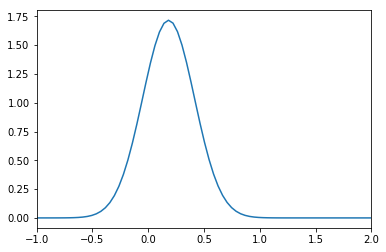

In [36]:
plt.plot(x_test, y_test)
plt.xlim(-1,2)

In [37]:
sum(y_test)

24.749999999999975

In [38]:
y_test2 = [norm.pdf(x, mu+1, sigma+2) for x in x_test]

(-3, 3)

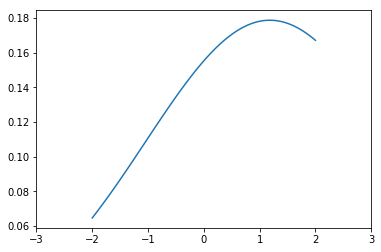

In [41]:
plt.plot(x_test, y_test2)
plt.xlim(-3,3)

In [18]:
### Stop from here

In [18]:
my.binary_code(learner)

In [19]:
test = learner.callbacks[0].outputs

In [20]:
ref9 = sum(test).float()/len(test) > 0.5

In [21]:
ref9

tensor([[0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
         1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]],
       dtype=torch.uint8)

In [131]:

for i in range(0,len(learner.callbacks[0].outputs)):
    print(my.similarity(learner.callbacks[0].outputs[i][0], ref9))
    

tensor(0.7708)
tensor(0.8333)
tensor(0.8750)
tensor(0.7708)
tensor(0.6875)
tensor(0.7292)
tensor(0.7917)
tensor(0.7083)
tensor(0.7292)
tensor(0.7292)
tensor(0.6042)
tensor(0.7500)
tensor(0.7708)
tensor(0.7083)
tensor(0.7500)
tensor(0.7292)
tensor(0.7083)
tensor(0.6875)
tensor(0.6667)
tensor(0.6875)


In [22]:
def test_accu(path):
    learner.callbacks[0].outputs = []
    my.run_folder(path, learner)
    my.binary_code(learner)
    avg_accu = 0
    for i in range(0,len(learner.callbacks[0].outputs)):
        print(my.similarity(learner.callbacks[0].outputs[i][0], ref9))
        avg_accu += my.similarity(learner.callbacks[0].outputs[i][0], ref9)
    print('avg_accu: ' + str(avg_accu/len(learner.callbacks[0].outputs)))

In [32]:
test_accu(path/'0')

tensor(0.3958)
tensor(0.4167)
tensor(0.4167)
tensor(0.4167)
tensor(0.4375)
tensor(0.4167)
tensor(0.4167)
tensor(0.4167)
tensor(0.3958)
tensor(0.4375)
avg_accu: tensor(0.4167)


In [23]:
test_accu(path/'1')

tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.3750)
tensor(0.3958)
tensor(0.3958)
tensor(0.3958)
tensor(0.8125)
tensor(0.3958)
tensor(0.4167)
avg_accu: tensor(0.4375)


In [24]:
test_accu(path/'2')

tensor(0.5625)
tensor(0.5417)
tensor(0.5417)
tensor(0.5417)
tensor(0.5417)
tensor(0.5417)
tensor(0.5625)
tensor(0.5417)
tensor(0.5417)
tensor(0.5417)
avg_accu: tensor(0.5458)


In [25]:
test_accu(path/'3')

tensor(0.4792)
tensor(0.5000)
tensor(0.5000)
tensor(0.4792)
tensor(0.4792)
tensor(0.5000)
tensor(0.4792)
tensor(0.4792)
tensor(0.5208)
tensor(0.5000)
avg_accu: tensor(0.4917)


In [26]:
test_accu(path/'4')

tensor(0.6250)
tensor(0.6042)
tensor(0.6042)
tensor(0.6042)
tensor(0.6042)
tensor(0.6042)
tensor(0.6042)
tensor(0.6042)
tensor(0.6042)
tensor(0.6042)
avg_accu: tensor(0.6062)


In [27]:
test_accu(path/'5')

tensor(0.4375)
tensor(0.4167)
tensor(0.4583)
tensor(0.4583)
tensor(0.4167)
tensor(0.4583)
tensor(0.4792)
tensor(0.4583)
tensor(0.4583)
tensor(0.4167)
avg_accu: tensor(0.4458)


In [28]:
test_accu(path/'6')

tensor(0.2917)
tensor(0.3125)
tensor(0.3125)
tensor(0.2917)
tensor(0.3125)
tensor(0.3125)
tensor(0.3125)
tensor(0.3125)
tensor(0.3125)
tensor(0.3125)
avg_accu: tensor(0.3083)


In [29]:
test_accu(path/'7')

tensor(0.9375)
tensor(0.9167)
tensor(0.9167)
tensor(0.9167)
tensor(0.9167)
tensor(0.8958)
tensor(0.7500)
tensor(0.9167)
tensor(0.9167)
tensor(0.9167)
avg_accu: tensor(0.9000)


In [30]:
test_accu(path/'8')

tensor(0.5417)
tensor(0.9375)
tensor(0.5208)
tensor(0.5208)
tensor(0.5417)
tensor(0.5208)
tensor(0.5000)
tensor(0.4583)
tensor(0.8333)
tensor(0.3750)
avg_accu: tensor(0.5750)


In [31]:
test_accu(path/'9')

tensor(0.9583)
tensor(0.4792)
tensor(0.7708)
tensor(0.9167)
tensor(0.9583)
tensor(0.7500)
tensor(0.9167)
tensor(0.9792)
tensor(0.9167)
tensor(0.6875)
tensor(0.9167)
tensor(0.9167)
tensor(0.9167)
tensor(0.8750)
tensor(0.9167)
tensor(0.9167)
tensor(0.9375)
tensor(0.9375)
tensor(0.9167)
tensor(0.8333)
tensor(0.7292)
tensor(0.7292)
tensor(0.7292)
tensor(0.9583)
tensor(0.6875)
tensor(0.9375)
tensor(0.7083)
tensor(0.6250)
tensor(0.8125)
tensor(0.9375)
tensor(0.9792)
tensor(0.8125)
tensor(1.)
tensor(0.9583)
tensor(1.)
tensor(0.8542)
tensor(0.8958)
tensor(0.9167)
tensor(0.9167)
tensor(0.8333)
tensor(0.9583)
tensor(0.8750)
tensor(0.8958)
tensor(0.4583)
tensor(0.9375)
tensor(0.6042)
tensor(0.9583)
tensor(0.4792)
tensor(0.8958)
tensor(0.7917)
tensor(0.7917)
tensor(0.9167)
tensor(0.8333)
tensor(0.8125)
tensor(0.9167)
tensor(0.9583)
tensor(0.8542)
tensor(0.6667)
tensor(0.9167)
tensor(0.8958)
tensor(0.9167)
tensor(0.9792)
tensor(0.5833)
tensor(0.9583)
tensor(0.6875)
tensor(0.9167)
tensor(0.9375)
ten